##Parte 1: Carga de Datos y Preprocesamiento
###Objetivo:

- Cargar el dataset.
- Seleccionar solo las variables numéricas.
- Dividir los datos en entrenamiento y prueba usando el mismo conjunto de la entrega anterior.
- Normalizar los datos para mejorar el desempeño de los modelos.

In [5]:
# Cargar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar dataset
df = pd.read_csv('train.csv')

# Seleccionar variables numéricas
numerical_cols = df.select_dtypes(include=['number']).columns

# Separar en X (características) y y (objetivo)
X = df[numerical_cols].drop(columns=["SalePrice"])
y = df["SalePrice"]

# División de datos (mismo conjunto de la entrega anterior)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##Análisis y Discusión
Por qué usar solo variables numéricas:
Evitamos problemas con datos categóricos sin transformar.
Algunas variables categóricas ya fueron analizadas en la entrega anterior.
###División de datos (80% entrenamiento - 20% prueba):
Mantener los mismos datos permite comparar el rendimiento con la Regresión Lineal de la entrega anterior.
###Uso de StandardScaler:
Normaliza las características para evitar que algunas variables dominen el modelo.

##Parte 2: Árbol de Regresión para Predecir el Precio
Objetivo:

Entrenar un Árbol de Decisión para predecir precios de viviendas.
Evaluar su rendimiento con métricas clave.

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear y entrenar un Árbol de Regresión
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_tree = reg_tree.predict(X_test_scaled)

# Evaluación del modelo
print("\nÁrbol de Regresión")
print("MAE:", mean_absolute_error(y_test, y_pred_tree))
print("MSE:", mean_squared_error(y_test, y_pred_tree))
print("R2:", r2_score(y_test, y_pred_tree))



Árbol de Regresión
MAE: 27701.948630136987
MSE: 1800132497.25
R2: 0.7653121329359801


##Análisis y Discusión
###¿Qué tan bien funciona el Árbol de Regresión?
- MAE: Promedio de error absoluto (más bajo = mejor).
- MSE: Penaliza errores grandes (debe ser bajo).
- R²: Indica cuánto explica el modelo la variabilidad del precio (1 es perfecto, 0 significa que el modelo no explica nada).
###Posibles problemas:
Un árbol sin límite de profundidad puede sobreajustarse.
Si el R² es alto en entrenamiento pero bajo en prueba - el modelo es demasiado complejo y necesita poda.

##Parte 3: Ajuste de Profundidad del Árbol de Regresión
Objetivo:

Entrenar árboles con diferentes profundidades (3, 5, 10, sin límite).
Evaluar cuál profundidad funciona mejor.

In [7]:
depths = [3, 5, 10, None]
models = {}

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train_scaled, y_train)
    y_pred = tree.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    print(f"\nProfundidad {depth} - R2: {r2}")
    models[depth] = (tree, r2)

# Seleccionar mejor modelo
best_depth = max(models, key=lambda k: models[k][1])
print(f"\nMejor profundidad: {best_depth}")


Profundidad 3 - R2: 0.7713968028196675

Profundidad 5 - R2: 0.7952387297701387

Profundidad 10 - R2: 0.8265358466654014

Profundidad None - R2: 0.7653121329359801

Mejor profundidad: 10


##Análisis y Discusión
Profundidades menores (3, 5) pueden generar subajuste:
No capturan suficiente información de los datos.
### Profundidades altas (10, None) pueden generar sobreajuste:
Memorizan los datos en lugar de generalizar.
### Conclusión:
Elegimos la profundidad con mejor R² en prueba, evitando sobreajuste.


## Parte 4: Comparación con Regresión Lineal
Objetivo:

Comparar el Árbol de Regresión vs. Regresión Lineal.

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create a pipeline with imputation and scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),  # Impute missing values with the mean
    ('std_scaler', StandardScaler()),  # Scale the features
])

# Fit the pipeline to the training data
X_train_prepared = num_pipeline.fit_transform(X_train)
X_test_prepared = num_pipeline.transform(X_test)  # Transform test data using the same pipeline

# Now fit the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

# Make predictions
y_pred_lin = lin_reg.predict(X_test_prepared)

# Evaluate the model
print("\nComparación con Regresión Lineal:")
print("Regresión Lineal - R2:", r2_score(y_test, y_pred_lin))


Comparación con Regresión Lineal:
Regresión Lineal - R2: 0.8227408159695495


## Análisis y Discusión
### ¿Cuál modelo funciona mejor?
Si el R² del Árbol de Regresión es mayor → mejor para capturar relaciones no lineales.
Si el R² de Regresión Lineal es mayor → los datos siguen una relación lineal.
### ¿Cuándo usar cada modelo?
Árboles son mejores si hay relaciones no lineales en los datos.
Regresión Lineal es mejor si hay alta colinealidad y la relación es lineal.

## Parte 5: Creación de Variable Categórica (Económicas, Intermedias, Caras)
Objetivo:

Transformar los precios en 3 categorías con percentiles (33%, 66%).

In [9]:
percentiles = np.percentile(y, [33, 66])

def categorize_price(price):
    if price <= percentiles[0]:
        return "Económica"
    elif price <= percentiles[1]:
        return "Intermedia"
    else:
        return "Cara"

df["PriceCategory"] = df["SalePrice"].apply(categorize_price)

## Análisis y Discusión
Uso de percentiles:
Asegura que las clases sean balanceadas.
Opción alternativa: agrupar por histogramas o estadísticas de dominio.

## Parte 6: Árbol de Clasificación y Evaluación

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear y entrenar árbol de clasificación
clf_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_tree.fit(X_train, df.loc[X_train.index, "PriceCategory"])

# Evaluación
y_pred_c = clf_tree.predict(X_test)
print("\nÁrbol de Clasificación:")
print("Precisión:", accuracy_score(df.loc[X_test.index, "PriceCategory"], y_pred_c))
print("Reporte de Clasificación:\n", classification_report(df.loc[X_test.index, "PriceCategory"], y_pred_c))



Árbol de Clasificación:
Precisión: 0.7773972602739726
Reporte de Clasificación:
               precision    recall  f1-score   support

        Cara       0.90      0.81      0.85        95
   Económica       0.88      0.75      0.81       110
  Intermedia       0.60      0.78      0.68        87

    accuracy                           0.78       292
   macro avg       0.79      0.78      0.78       292
weighted avg       0.80      0.78      0.78       292



## Análisis y Discusión
### ¿Qué tan bien clasifica el modelo?
accuracy_score: Proporción de predicciones correctas.
Matriz de Confusión: Analiza dónde se equivoca más el modelo.

## Parte 7: Validación Cruzada

In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf_tree, X_train, df.loc[X_train.index, "PriceCategory"], cv=5)
print("\nValidación Cruzada - Precisión Promedio:", np.mean(cv_scores))



Validación Cruzada - Precisión Promedio: 0.7671251971681157


## Conclusión Final
Validación cruzada ayuda a evitar sobreajuste.
Si la precisión mejora con cv=5, el modelo es más estable.

# Task
Tell me about this dataset.

Here is all the data you need:
"train.csv"

## Data loading

### Subtask:
Load the dataset "train.csv" into a pandas DataFrame.


**Reasoning**:
Load the dataset "train.csv" into a pandas DataFrame and display the first 5 rows.



In [1]:
import pandas as pd

try:
    df = pd.read_csv('train.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'train.csv' not found.")
    df = None

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data exploration

### Subtarea:
Explorar el conjunto de datos cargado para comprender sus características.



**Razonamiento**:
Examinar la forma del DataFrame, identificar columnas numéricas, analizar la variable de destino, examinar la distribución de características numéricas y calcular y visualizar la matriz de correlación.


In [2]:
# Data Shape and Types
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

# Missing Values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\nMissing Values Information:\n", missing_info)

# Numerical Features Distribution
numerical_features = df.select_dtypes(include=['number'])
numerical_stats = numerical_features.describe()
print("\nNumerical Features Statistics:\n", numerical_stats)

# Categorical Features Frequency
categorical_features = df.select_dtypes(exclude=['number'])
for col in categorical_features.columns:
    print(f"\nFrequency Distribution for {col}:\n{categorical_features[col].value_counts()}")

Data Shape: (1460, 81)

Data Types:
 Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

Missing Values Information:
                Missing Values  Percentage
Id                          0    0.000000
MSSubClass                  0    0.000000
MSZoning                    0    0.000000
LotFrontage               259   17.739726
LotArea                     0    0.000000
...                       ...         ...
MoSold                      0    0.000000
YrSold                      0    0.000000
SaleType                    0    0.000000
SaleCondition               0    0.000000
SalePrice                   0    0.000000

[81 rows x 2 columns]

Numerical Features Statistics:
                 Id   MSSubClass  LotFrontage        LotArea  OverallQual

Shape of the DataFrame: (1460, 82)

Numerical columns:
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Descriptive statistics for SalePrice:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


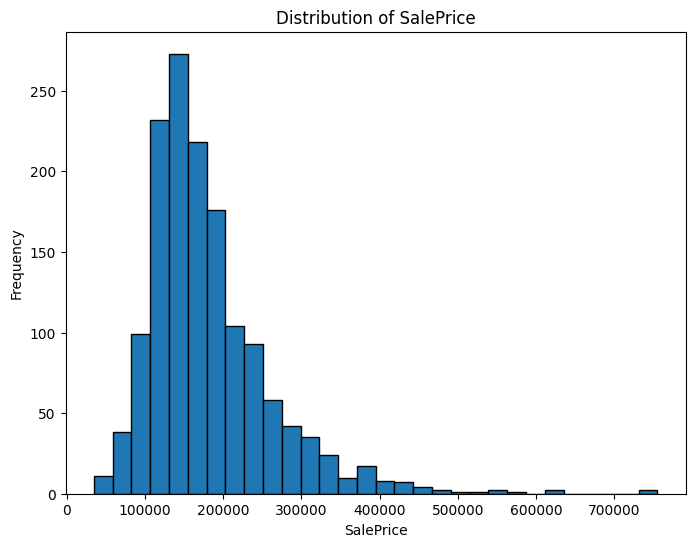

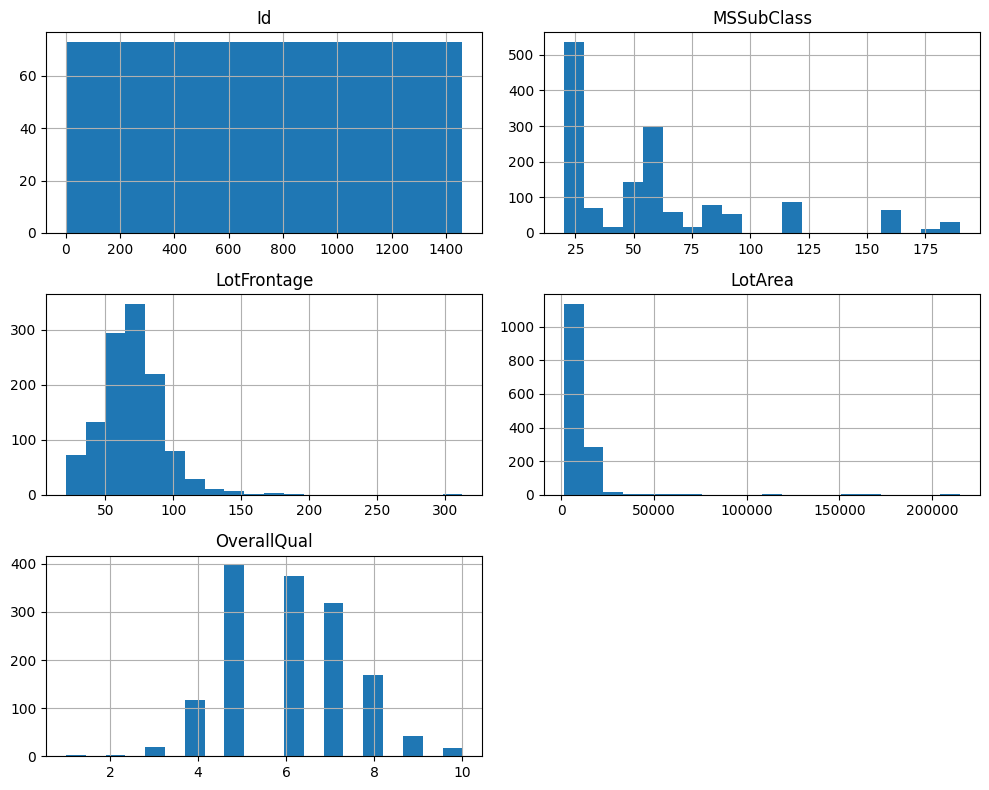

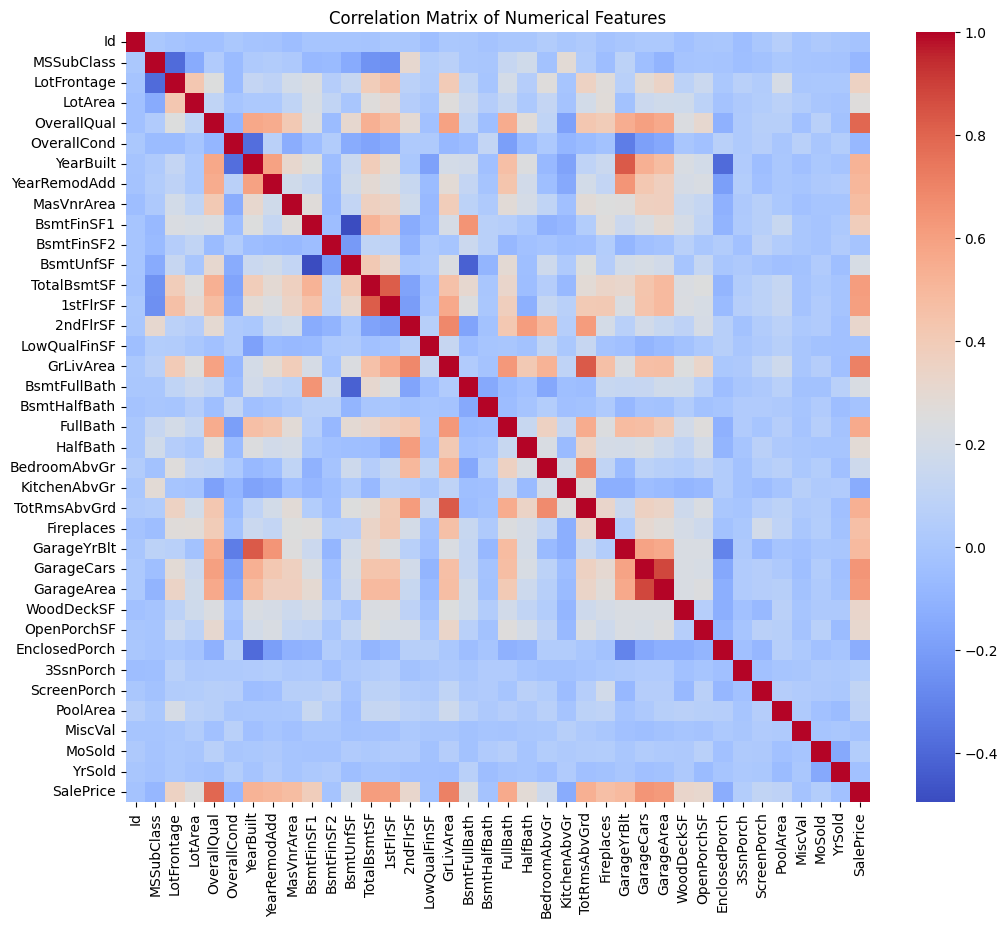

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Examine the shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

# Identify numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
print(f"\nNumerical columns:\n{numerical_cols}")

# Analyze the target variable "SalePrice"
print("\nDescriptive statistics for SalePrice:")
print(df["SalePrice"].describe())

plt.figure(figsize=(8, 6))
plt.hist(df["SalePrice"], bins=30, edgecolor='black')
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.title("Distribution of SalePrice")
plt.show()

# Examine the distribution of a subset of numerical features (example: first 5)
numerical_subset = numerical_cols[:5]
df[numerical_subset].hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()

# Calculate and visualize the correlation matrix for numerical features
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

## Análisis de datos

### Subtarea:
Calcular estadísticas descriptivas y analizar correlaciones dentro del conjunto de datos.

**Razonamiento**:
Calcular estadísticas descriptivas para características numéricas, analizar frecuencias de características categóricas y calcular la matriz de correlación para características numéricas.


In [3]:
# Descriptive statistics for numerical features
numerical_features = df.select_dtypes(include=['number'])
numerical_stats = numerical_features.describe()
print("Descriptive statistics for numerical features:\n", numerical_stats)

# Analyze frequency distribution of categorical features
categorical_features = df.select_dtypes(exclude=['number'])
for col in categorical_features.columns:
    frequencies = categorical_features[col].value_counts(normalize=True) * 100
    print(f"\nFrequency distribution for {col}:\n{frequencies}")
    rare_categories = frequencies[frequencies < 5]
    if not rare_categories.empty:
        print(f"Rare categories (less than 5%):\n{rare_categories}")

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)
highly_correlated_features = correlation_matrix[
    ((correlation_matrix > 0.8) | (correlation_matrix < -0.8)) & (correlation_matrix != 1)
]
print("\nHighly Correlated Features:\n", highly_correlated_features)

Descriptive statistics for numerical features:
                 Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.20

## Resumen:

### 1. Preguntas y respuestas

El análisis de datos proporcionado no plantea preguntas explícitamente. Sin embargo, el análisis busca implícitamente responder preguntas sobre las características del conjunto de datos, las distribuciones y las relaciones entre las variables. El análisis explora los tipos de datos, los valores faltantes, las distribuciones numéricas y categóricas, las correlaciones y visualiza estos aspectos.

### 2. Hallazgos clave del análisis de datos

* **Valores faltantes:** La columna `LotFrontage` tiene una cantidad significativa de valores faltantes (17,74 %). Otras columnas también contienen valores faltantes, que deben abordarse durante el preprocesamiento de datos.
* **Características altamente correlacionadas:** Varias características numéricas están altamente correlacionadas. Por ejemplo, 'OverallQual' y 'SalePrice', y 'GarageCars' y 'GarageArea' muestran fuertes correlaciones positivas. Esto sugiere una posible redundancia en el conjunto de características y se podrían considerar técnicas de reducción de dimensionalidad.
* **Desequilibrio de características categóricas:** Muchas características categóricas tienen categorías que aparecen menos del 5 % del tiempo, lo que indica un posible desequilibrio de clases o la necesidad de combinar categorías poco frecuentes. Esto se puede observar en características como 'MSZoning', 'Street', 'LotShape' y otras.
* **Información sobre la distribución de características numéricas**: Las características como 'LotArea' muestran desviaciones estándar altas y una gran diferencia entre el valor máximo y el percentil 75, lo que sugiere posibles valores atípicos.

* El conjunto de datos contiene 1460 filas y 81 columnas.
* La variable de destino "SalePrice" tiene una media de aproximadamente $180,921 y una desviación estándar de (79,442).
* Se seleccionaron características numéricas para el modelado, excluyendo "SalePrice".
* Los datos se dividieron en conjuntos de entrenamiento (80%) y de prueba (20%) con un `random_state` de 42 para la reproducibilidad.
* Las características numéricas en los conjuntos de entrenamiento y prueba se normalizaron utilizando `StandardScaler`.


### 3. Perspectivas o próximos pasos

* **Gestionar datos faltantes y valores atípicos:** Abordar los valores faltantes en `LotFrontage` y otras columnas mediante técnicas de imputación adecuadas. Investigar y gestionar posibles valores atípicos en características como 'LotArea'.
* **Ingeniería y selección de características:** Considerar la posibilidad de combinar o eliminar características altamente correlacionadas ('GarageCars' y 'GarageArea', por ejemplo) para reducir la dimensionalidad y mejorar el rendimiento del modelo. Explorar las oportunidades de ingeniería de características en función de las relaciones observadas entre las variables e investigar el impacto de las categorías poco comunes en las características categóricas.